<a href="https://colab.research.google.com/github/ZohebAbai/Deep-Learning-Projects/blob/master/Tensorflow_Keras/01_TF_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression

We're going to try predict the cost of medical insurance for individuals based on a number of different parameters such as, age, sex, bmi, children, smoking_status and residential_region.

Steps covered:
1. Import Libraries
2. Downloading and View Dataset
3. EDA (Not explored here)
4. Data Preprocessing --- Splitting, Normalization and One hot encoding
5. Model Building and Training
6. Model Evaluation and Prediction


### Check the GPU

In [1]:
!nvidia-smi

Sat Dec  4 12:55:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import libraries

In [11]:
# Import required libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

print(tf.__version__)

2.7.0


## Downloading and View Dataset

In [3]:
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [19]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## Data Preprocessing --- Splitting, Normalization and One hot encoding

We will convert categorical variables (like the sex, smoker and region columns) into numerical variables using one-hot encoding. We'll also be normalizing the numerical columns to make sure they're all between a range.

In [4]:
# Create column transformer (this will help us preprocess our data)
ct = make_column_transformer(
    (StandardScaler(), ["age", "bmi", "children"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

# Create X & y
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

print(X_train_normal[0])

[-1.15786012 -0.68882801 -0.92785237  0.          1.          1.
  0.          0.          0.          1.          0.        ]


In [5]:
print(X_train_normal.shape)
print(X_test_normal.shape)

(1070, 11)
(268, 11)


## Model Building and Training

In [6]:
tf.random.set_seed(101)

model = tf.keras.Sequential([
                             tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_normal.shape[1],)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.mse,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-02),
              metrics=["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,905
Trainable params: 11,905
Non-trainable params: 0
_________________________________________________________________


In [7]:
#checkpointer
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="bestmodel.h5", verbose=0, mode='min',
                               save_best_only=True, monitor="loss")

# training
history = model.fit(X_train_normal, y_train, epochs=250, callbacks=[checkpointer], verbose=0)

### Plot Training Loss History

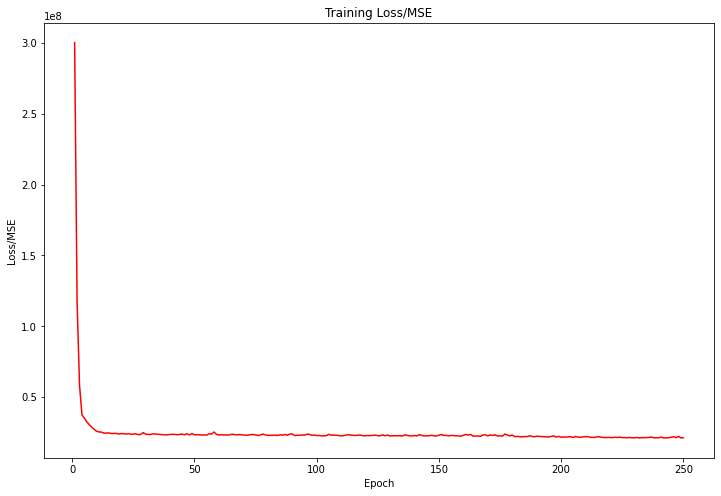

In [8]:
# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(range(1,len(history.history['loss'])+1), history.history['loss'], color="red")
plt.title('Training Loss/MSE')
plt.ylabel('Loss/MSE')
plt.xlabel('Epoch')
plt.show()

## Model Evaluation and Prediction

In [9]:
bestmodel = tf.keras.models.load_model("bestmodel.h5")

# Evaluation
score= bestmodel.evaluate(X_test_normal, y_test)
print("Minimal Training MAE Score : ", score[1])

9/9 [==============================] - 0s 2ms/step - loss: 20537996.0000 - mae: 2935.1836
Minimal Training MAE Score :  2935.18359375


In [10]:
y_pred = bestmodel.predict(tf.expand_dims(X_test_normal[17], axis=0))
print(f"Pred Value: {y_pred[0][0]} \n Ground Truth: {np.array(y_test)[17]}")

Pred Value: 4317.03662109375 
 Ground Truth: 4391.652
